In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Kaggle/cleaned_4.csv"

# 1. Load the cleaned dataset
df = pd.read_csv(data_path)

# 2. Select the risk-related features (all numerical columns relevant to credit risk)
# We exclude account identifiers and any categorical descriptors that we don't want to use directly.
risk_features = [
    "utilization_rate",                   # How much of the credit limit is being used.
    "open_to_buy",                        # Available credit remaining.
    "current_balance",                    # Amount currently owed.
    "max_days_delinquent",                # Longest period past due.
    "current_cycles_delinquent",          # Number of billing cycles past due.
    "balance_to_credit_ratio",            # Ratio of current balance to credit limit.
    "cash_balance_to_cash_line_ratio",    # Cash usage relative to cash advance limit.
    "credit_grade_numeric",               # Converted credit quality rating.
    "months_since_active",                # Time since last account activity.
    "months_since_credit_limit_change",   # Time since last credit limit change.
    "utilization_stability",              # Consistency of credit usage.
    "financial_stress_indicator",         # Measure of financial pressure.
    "months_on_books",                    # Account age.
    "total_sales_last_6_months",          # Spending volume.
    "avg_monthly_sales_last_6_months",    # Typical monthly spending.
    "sales_trend",                        # Direction of spending changes.
    "nsf_count_last_12_months",           # Number of insufficient funds incidents.
    "behavior_score_change",              # Shift in internal risk score.
    "behavior_score_percent_change",      # Percentage change in risk score.
    "high_delinquency_flag",              # Indicator of serious delinquency.
    "rapid_balance_change_flag",          # Indicator of sudden balance changes.
    "fraud_risk_score",                   # Composite score of fraud likelihood.
    "sales_volatility",                   # Inconsistency in spending patterns.
    "spending_to_balance_ratio",          # Spending relative to carried balance.
    "external_credit_score",              # Third-party credit score.
    "weighted_utilization",               # Blended utilization measure.
    "credit_limit_utilization_trend",     # Direction of utilization changes.
    "income_stability_score",             # Consistency of income.
    "cash_balance",                       # Available cash in the account.
    "cash_balance_pct_credit_line",       # Cash as percentage of credit line.
    "cash_buffer_ratio"                   # Cash relative to typical spending.
]

# Check if all risk features are present; if not, report missing ones.
missing_cols = [col for col in risk_features if col not in df.columns]
if missing_cols:
    print("Missing columns in dataset:", missing_cols)
else:
    print("All risk features are present.")

df.head()

Mounted at /content/drive
All risk features are present.


,current_account_nbr,client_id,open_date,card_activation_date,card_activation_flag,external_status_reason_code,pscc_ind,open_date_naive,age_days,activation_status_numeric,...,sales_change_month_1_to_2,sales_change_month_2_to_3,sales_change_month_3_to_4,sales_change_month_4_to_5,sales_change_month_5_to_6,customer_lifecycle_stage_encoded,account_card_type_encoded,ebill_ind_encoded,fraud_indicator,employee_code_encoded
0,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,NaN,8,0,0,2020-07-17,1716.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1,0,2,0,-1
1,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,NaN,8,0,0,2020-07-17,1716.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1,0,2,0,-1
2,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,NaN,8,0,0,2020-07-17,1716.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1,0,2,0,-1
3,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,NaN,8,0,0,2020-07-17,1716.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1,0,2,0,-1
4,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,NaN,8,0,0,2020-07-17,1716.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1,0,2,0,-1


In [2]:
df.shape

(97099, 213)

In [3]:
df.describe()

,external_status_reason_code,pscc_ind,age_days,activation_status_numeric,ebill_ind_numeric,employee_code_numeric,pscc_ind_numeric,external_status_numeric,2023Q1_SALE_avg_spending,2023Q2_RETURN_avg_spending,...,sales_change_month_1_to_2,sales_change_month_2_to_3,sales_change_month_3_to_4,sales_change_month_4_to_5,sales_change_month_5_to_6,customer_lifecycle_stage_encoded,account_card_type_encoded,ebill_ind_encoded,fraud_indicator,employee_code_encoded
count,97099.000000,97099.000000,64541.000000,96214.000000,68225.000000,17054.0,97099.000000,97099.000000,9.709900e+04,9.709900e+04,...,96799.000000,96799.00000,96799.000000,96799.000000,96799.000000,97099.000000,97099.000000,97099.000000,97099.000000,97099.000000
mean,5.484588,0.224287,2174.876590,1.027813,2.193932,2.0,0.224287,0.041576,1.928300e+02,1.509053e+03,...,-7.351811,-10.67638,0.930827,3.013443,-9.452311,0.872635,0.489933,2.714292,0.136520,-0.824118
std,14.513463,0.417114,2337.799645,2.568140,0.411189,0.0,0.417114,0.199620,1.243339e-10,1.667293e-09,...,1173.722425,1162.65998,1144.076276,1135.713727,1145.694799,0.480584,0.499901,0.912639,0.343342,0.381046
min,0.000000,0.000000,6.000000,0.000000,1.000000,2.0,0.000000,0.000000,1.928300e+02,1.509053e+03,...,-40200.000000,-40200.00000,-41222.000000,-41222.000000,-41222.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000
25%,0.000000,0.000000,522.000000,0.000000,2.000000,2.0,0.000000,0.000000,1.928300e+02,1.509053e+03,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,-1.000000
50%,0.000000,0.000000,1363.000000,0.000000,2.000000,2.0,0.000000,0.000000,1.928300e+02,1.509053e+03,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,-1.000000
75%,0.000000,0.000000,3232.000000,0.000000,2.000000,2.0,0.000000,0.000000,1.928300e+02,1.509053e+03,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,0.000000,-1.000000
max,97.000000,1.000000,22216.000000,8.000000,3.000000,2.0,1.000000,1.000000,1.928300e+02,1.509053e+03,...,40200.000000,40200.00000,40200.000000,41222.000000,41222.000000,2.000000,1.000000,4.000000,1.000000,1.000000


In [4]:
# 4.1. Drop columns with too many missing values
#     Here we use a threshold of 50% missing as an example.
drop_threshold = 0.5
cols_to_drop = []
for col in df.columns:
    # print(col)
    missing_ratio = df[col].isnull().sum() / len(df)
    print(col, missing_ratio)
    if missing_ratio > drop_threshold:
        cols_to_drop.append(col)

if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"Dropped columns with missing ratio > {drop_threshold}: {cols_to_drop}")
else:
    print("No columns were dropped based on the missing value threshold.")

# 4.2. Drop or flag single-valued columns (which add no variance)
single_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
if single_value_cols:
    df.drop(columns=single_value_cols, inplace=True)
    print(f"Dropped single-valued columns: {single_value_cols}")
else:
    print("No single-valued columns found to drop.")

# 4.3. Separate remaining numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

# 4.4. Fill missing values in numeric columns with median
for col in num_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in numeric column '{col}' with median: {median_val}")

# 4.5. Fill missing values in categorical columns with mode
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with mode: '{mode_val}'")

print("\nData Cleaning & Imputation Completed.")
print("Remaining missing values after imputation:")
print(df.isnull().sum())

df.head(10)


current_account_nbr 0.0
client_id 0.0
open_date 0.33530726372053266
card_activation_date 0.14652056148878978
card_activation_flag 0.0
external_status_reason_code 0.0
pscc_ind 0.0
open_date_naive 0.33530726372053266
age_days 0.33530726372053266
activation_status_numeric 0.009114409005242073
ebill_ind_numeric 0.2973666052173555
employee_code_numeric 0.8243648235306233
pscc_ind_numeric 0.0
external_status_numeric 0.0
2023Q1_SALE_avg_spending 0.0
2023Q2_RETURN_avg_spending 0.0
2023Q3_RETURN_avg_spending 0.0
2023Q4_RETURN_avg_spending 0.0
2023Q4_SALE_avg_spending 0.0
2024Q1_ADJUSTMENT_avg_spending 0.0
2024Q1_PAYMENT_avg_spending 0.0
2024Q1_RETURN_avg_spending 0.0
2024Q1_SALE_avg_spending 0.0
2024Q2_ADJUSTMENT_avg_spending 0.0
2024Q2_PAYMENT_avg_spending 0.0
2024Q2_RETURN_avg_spending 0.0
2024Q2_SALE_avg_spending 0.0
2024Q3_ADJUSTMENT_avg_spending 0.0
2024Q3_PAYMENT_avg_spending 0.0
2024Q3_RETURN_avg_spending 0.0
2024Q3_SALE_avg_spending 0.0
2024Q4_ADJUSTMENT_avg_spending 0.0
2024Q4_PAYMENT_

<ipython-input-4-90210f764c0d>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
<ipython-input-4-90210f764c0d>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

Filled missing values in categorical column 'customer_lifecycle_stage' with mode: 'Mature'

Data Cleaning & Imputation Completed.
Remaining missing values after imputation:
current_account_nbr                 0
client_id                           0
open_date                           0
card_activation_date                0
card_activation_flag                0
                                   ..
customer_lifecycle_stage_encoded    0
account_card_type_encoded           0
ebill_ind_encoded                   0
fraud_indicator                     0
employee_code_encoded               0
Length: 188, dtype: int64


,current_account_nbr,client_id,open_date,card_activation_date,card_activation_flag,external_status_reason_code,pscc_ind,open_date_naive,age_days,activation_status_numeric,...,sales_change_month_1_to_2,sales_change_month_2_to_3,sales_change_month_3_to_4,sales_change_month_4_to_5,sales_change_month_5_to_6,customer_lifecycle_stage_encoded,account_card_type_encoded,ebill_ind_encoded,fraud_indicator,employee_code_encoded
0,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,2019-04-26T00:00:00.000-04:00,8,0,0,2020-07-17,1716.0,8.0,...,0.00,0.00,0.00,0.00,0.00,1,0,2,0,-1
1,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,2019-04-26T00:00:00.000-04:00,8,0,0,2020-07-17,1716.0,8.0,...,0.00,0.00,0.00,0.00,0.00,1,0,2,0,-1
2,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,2019-04-26T00:00:00.000-04:00,8,0,0,2020-07-17,1716.0,8.0,...,0.00,0.00,0.00,0.00,0.00,1,0,2,0,-1
3,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,2019-04-26T00:00:00.000-04:00,8,0,0,2020-07-17,1716.0,8.0,...,0.00,0.00,0.00,0.00,0.00,1,0,2,0,-1
4,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,2019-04-26T00:00:00.000-04:00,8,0,0,2020-07-17,1716.0,8.0,...,0.00,0.00,0.00,0.00,0.00,1,0,2,0,-1
5,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,2019-04-26T00:00:00.000-04:00,8,0,0,2020-07-17,1716.0,8.0,...,0.00,0.00,0.00,0.00,0.00,1,0,2,0,-1
6,xYaLrD9IvmbVl1PB,CCSP489PLCC,2024-07-24 00:00:00-04:00,2024-08-09T00:00:00.000-04:00,0,0,1,2024-07-24,248.0,0.0,...,-788.88,788.88,-1318.90,1318.90,0.00,0,0,2,0,-1
7,xYaLrD9IvmbVl1PB,CCSP489PLCC,2024-07-24 00:00:00-04:00,2024-08-09T00:00:00.000-04:00,0,0,1,2024-07-24,248.0,0.0,...,0.00,0.00,-788.88,788.88,-1318.90,0,0,2,0,-1
8,xYaLrD9IvmbVl1PB,CCSP489PLCC,2024-07-24 00:00:00-04:00,2024-08-09T00:00:00.000-04:00,0,0,1,2024-07-24,248.0,0.0,...,-94.16,94.16,0.00,0.00,-788.88,0,0,2,0,-1
9,xYaLrD9IvmbVl1PB,CCSP489PLCC,2024-07-24 00:00:00-04:00,2024-08-09T00:00:00.000-04:00,0,0,1,2024-07-24,248.0,0.0,...,0.00,-788.88,788.88,-1318.90,1318.90,0,0,2,0,-1


In [5]:
df.shape

(97099, 188)

In [6]:
risk_features = [feature for feature in risk_features if feature not in cols_to_drop]
# 3. Create the data subset for the autoencoder
ae_data = df[risk_features].copy()

# 4. Scale the data – autoencoders benefit from scaled input (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ae_data)

# 5. Split the data into training and test sets.
# Note: We save the indices from the test set to map the anomalies back to the original records.
X_train, X_test, idx_train, idx_test = train_test_split(X_scaled, df.index, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

print("Any NaNs in X_train:", np.any(np.isnan(X_train)))
print("Any Infs in X_train:", np.any(np.isinf(X_train)))


Training set shape: (77679, 30)
Testing set shape: (19420, 30)
Any NaNs in X_train: False
Any Infs in X_train: False


In [19]:
# 6. Build the autoencoder.
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)  # A simple heuristic: compress to half the input dimensions

# Encoder 2 layers for complex model design
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim/2), activation="relu")(encoder)

# Decoder
decoder = Dense(input_dim, activation="linear")(encoder)

# Assemble the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()

# 7. Train the autoencoder on the training set
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)

# 8. Compute reconstruction errors on the test set
X_test_pred = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)

# 9. Set an anomaly threshold
threshold = reconstruction_errors.mean() + 0.5 * reconstruction_errors.std()
print("Reconstruction error threshold:", threshold)

# 10. Identify anomalous test samples (high reconstruction error)
anomaly_test_indices = np.where(reconstruction_errors > threshold)[0]
print("Number of anomalies detected:", len(anomaly_test_indices))

# Map the indices back to the original DataFrame and extract anomaly rows.
anomaly_original_indices = idx_test[anomaly_test_indices]
anomalies_df = df.loc[anomaly_original_indices]
print("Extracted anomaly rows (risk candidates):")
display(anomalies_df.head())


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 30)                  │             240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 817 (3.19 KB)

 Trainable params: 817 (3.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.8890 - val_loss: 0.5268
Epoch 2/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5305 - val_loss: 0.4437
Epoch 3/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5274 - val_loss: 0.4210
Epoch 4/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5170 - val_loss: 0.4084
Epoch 5/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4884 - val_loss: 0.4015
Epoch 6/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4044 - val_loss: 0.3991
Epoch 7/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5024 - val_loss: 0.3927
Epoch 8/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4562 - val_loss: 0.3946
Epoch 9/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4271 - val_loss: 0.3881
Epoch 10/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4253 - val_loss: 0.3898
Epoch 11/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4304 - val_loss: 0.3862
Epoch 12/50
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

,current_account_nbr,client_id,open_date,card_activation_date,card_activation_flag,external_status_reason_code,pscc_ind,open_date_naive,age_days,activation_status_numeric,...,sales_change_month_1_to_2,sales_change_month_2_to_3,sales_change_month_3_to_4,sales_change_month_4_to_5,sales_change_month_5_to_6,customer_lifecycle_stage_encoded,account_card_type_encoded,ebill_ind_encoded,fraud_indicator,employee_code_encoded
78870,4jBU8L48mWxV3aZX,OCAOAZNMN549,2024-05-26 00:00:00-04:00,2025-01-29T00:00:00.000-05:00,0,43,0,2024-05-26,1363.0,0.0,...,0.0,0.00,0.00,0.0,0.0,2,1,3,0,-1
17063,TH23dMPd7T4QIbA5,OCAOAZNMN549,2024-05-26 00:00:00-04:00,2025-02-14T00:00:00.000-05:00,0,43,0,2024-05-26,1363.0,0.0,...,0.0,0.00,0.00,0.0,0.0,2,1,3,0,-1
65885,i9yzLlsd377BH1UX,RGALNW318DC,2024-05-26 00:00:00-04:00,2021-12-30T00:00:00.000-05:00,0,0,0,2024-05-26,1363.0,0.0,...,0.0,-1.55,1.55,0.0,0.0,1,0,2,0,-1
17076,BGtu4UlqrMGlrXbi,OCAOAZNMN549,2024-05-26 00:00:00-04:00,2025-02-04T00:00:00.000-05:00,0,43,0,2024-05-26,1363.0,0.0,...,0.0,0.00,0.00,0.0,0.0,2,1,3,0,-1
78908,coeEldgh0swNGiG9,OCAOAZNMN549,2024-05-26 00:00:00-04:00,2025-02-10T00:00:00.000-05:00,0,43,0,2024-05-26,1363.0,0.0,...,0.0,0.00,0.00,0.0,0.0,2,1,3,0,-1


Top risk features correlated with the anomaly flag:
                                  corr_with_anomaly  abs_corr
weighted_utilization                      -0.627808  0.627808
utilization_rate                          -0.620667  0.620667
utilization_stability                      0.266283  0.266283
cash_buffer_ratio                         -0.248027  0.248027
months_since_active                       -0.141648  0.141648
spending_to_balance_ratio                 -0.138563  0.138563
high_delinquency_flag                      0.138493  0.138493
nsf_count_last_12_months                   0.085785  0.085785
external_credit_score                     -0.081917  0.081917
cash_balance_to_cash_line_ratio            0.052098  0.052098
sales_trend                                0.050093  0.050093
rapid_balance_change_flag                  0.046885  0.046885
fraud_risk_score                           0.046227  0.046227
income_stability_score                     0.034265  0.034265
months_since_credi

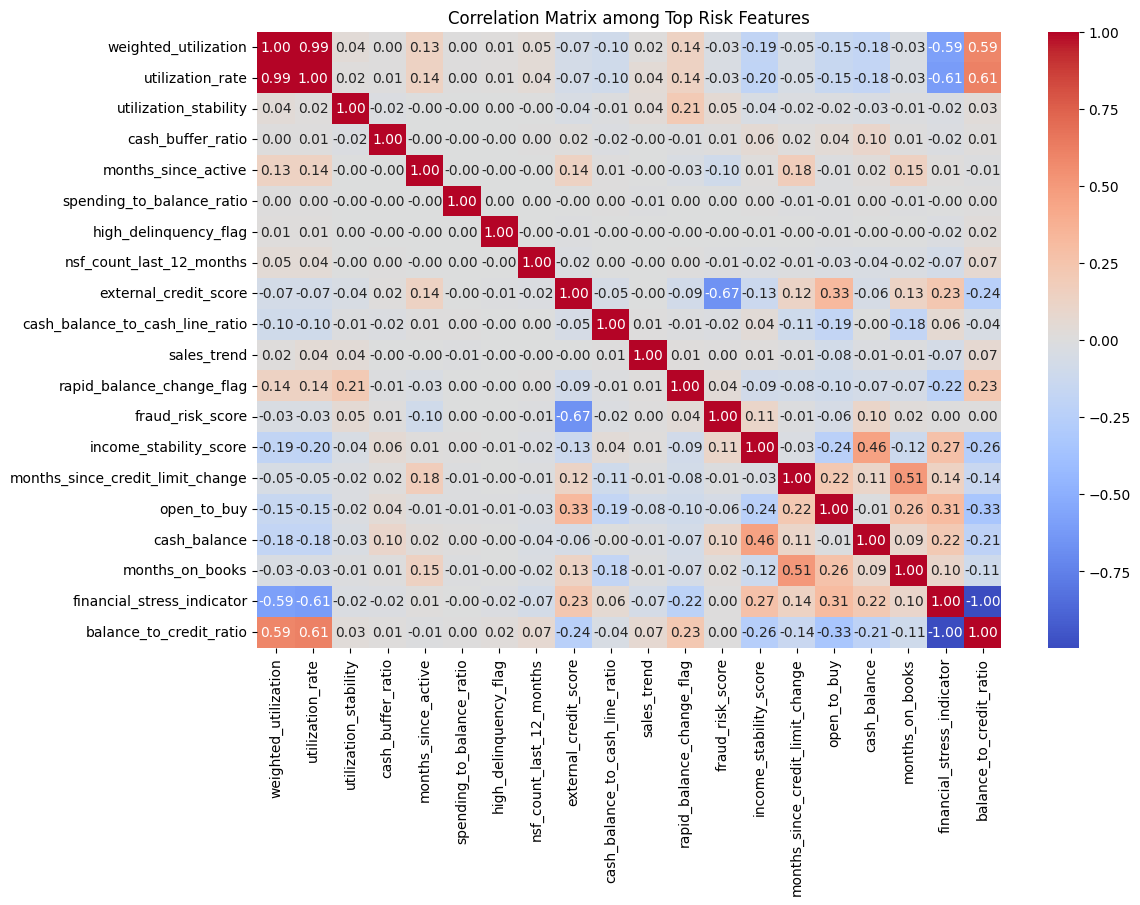

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

anomaly_flag = np.where(reconstruction_errors > threshold, 1, 0)

# Create a DataFrame for the test set with risk features and the anomaly flag.
test_df = df.loc[idx_test].copy()
test_df["anomaly_flag"] = anomaly_flag

# Calculate correlation of each risk feature with the anomaly flag.
correlations = {}
for feature in risk_features:
    if pd.api.types.is_numeric_dtype(test_df[feature]):
        corr_val = test_df[feature].corr(test_df["anomaly_flag"])
        correlations[feature] = corr_val

# Convert the correlations to a DataFrame and rank by absolute correlation.
corr_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["corr_with_anomaly"])
corr_df["abs_corr"] = corr_df["corr_with_anomaly"].abs()
top_features = corr_df.sort_values("abs_corr", ascending=False).head(20).index.tolist()

print("Top risk features correlated with the anomaly flag:")
print(corr_df.sort_values("abs_corr", ascending=False).head(20))

# Now, plot the correlation matrix of these top features.
plt.figure(figsize=(12, 8))
corr_matrix_top = test_df[top_features].corr()
sns.heatmap(corr_matrix_top, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix among Top Risk Features")
plt.show()


Top 5 features for anomaly comparison: ['weighted_utilization', 'utilization_rate', 'utilization_stability', 'cash_buffer_ratio', 'months_since_active']
Number of anomaly records: 52


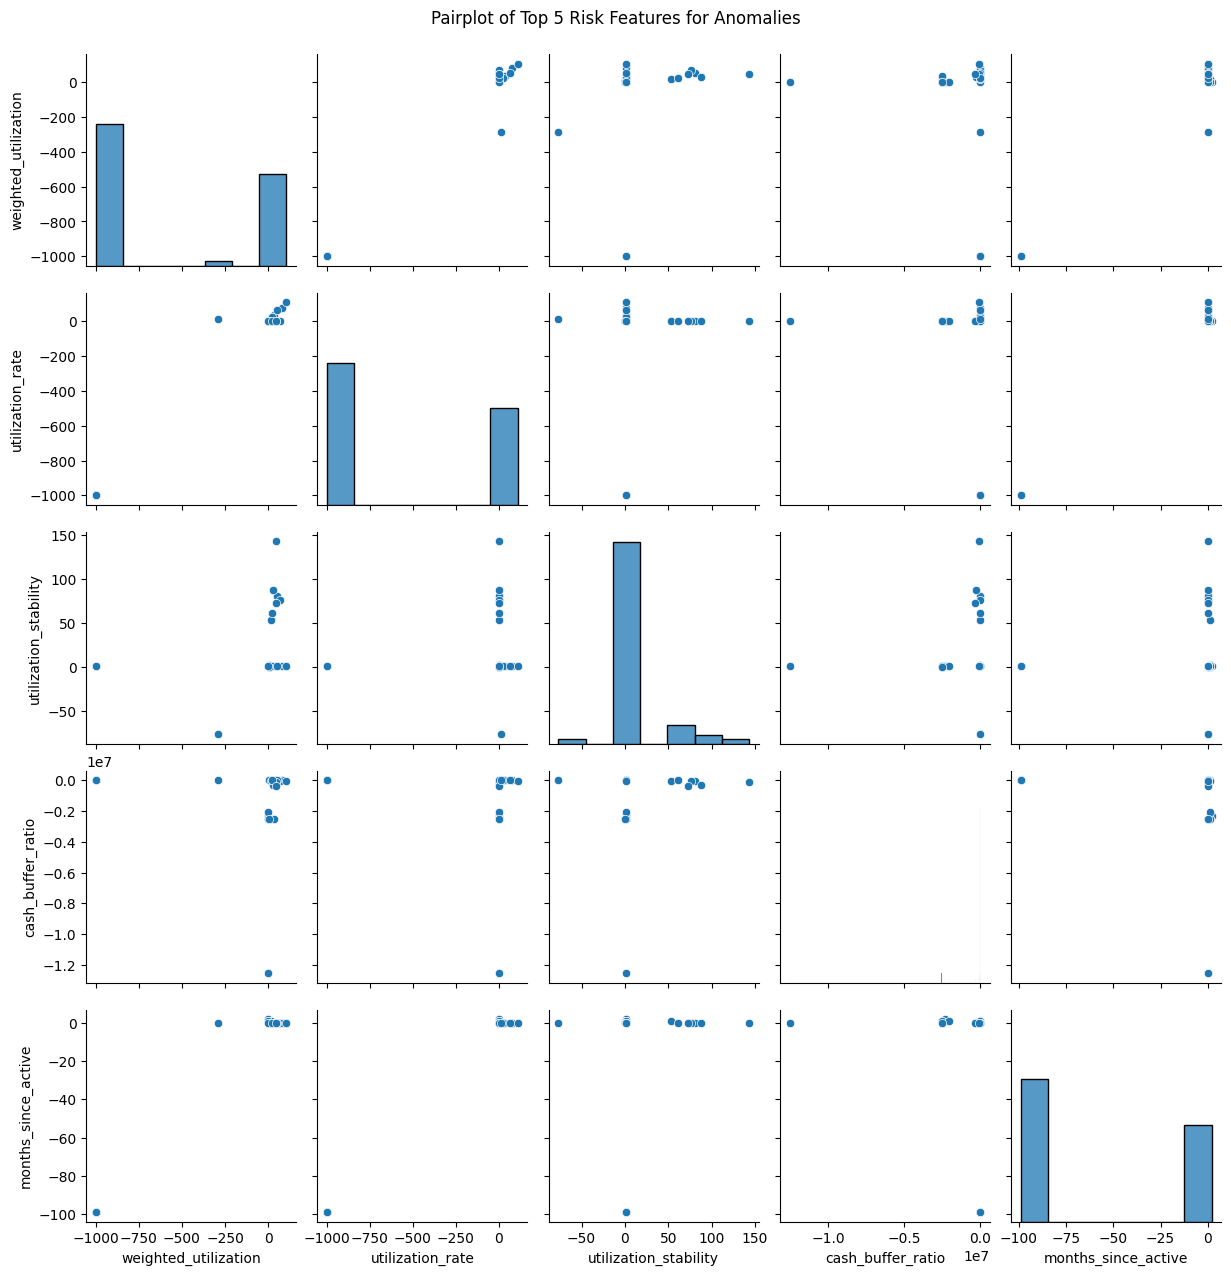

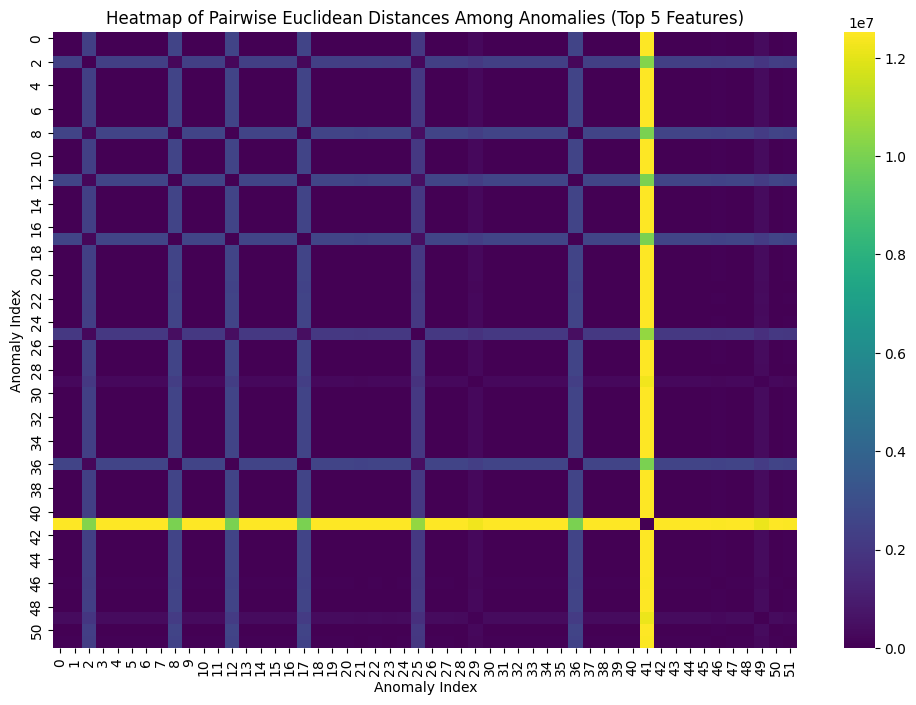

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Select top 5 features (from top_features if available; otherwise, use first 5 risk_features)
if 'top_features' in globals():
    top5_features = top_features[:5]
else:
    top5_features = risk_features[:5]

print("Top 5 features for anomaly comparison:", top5_features)

# Filter the test DataFrame to only include anomaly rows.
anomalies_only = test_df[test_df['anomaly_flag'] == 1]
print("Number of anomaly records:", anomalies_only.shape[0])

# 1. Pairplot to visualize relationships among anomalies for the top 5 features.
sns.pairplot(anomalies_only[top5_features])
plt.suptitle("Pairplot of Top 5 Risk Features for Anomalies", y=1.02)
plt.show()

# 2. Compute pairwise distances in the top 5 feature space.
anomaly_values = anomalies_only[top5_features].values
pairwise_dists = squareform(pdist(anomaly_values, metric='euclidean'))

plt.figure(figsize=(12, 8))
sns.heatmap(pairwise_dists, cmap="viridis")
plt.title("Heatmap of Pairwise Euclidean Distances Among Anomalies (Top 5 Features)")
plt.xlabel("Anomaly Index")
plt.ylabel("Anomaly Index")
plt.show()


Mean pairwise distance among anomalies in the selected features: 988329.5587057348


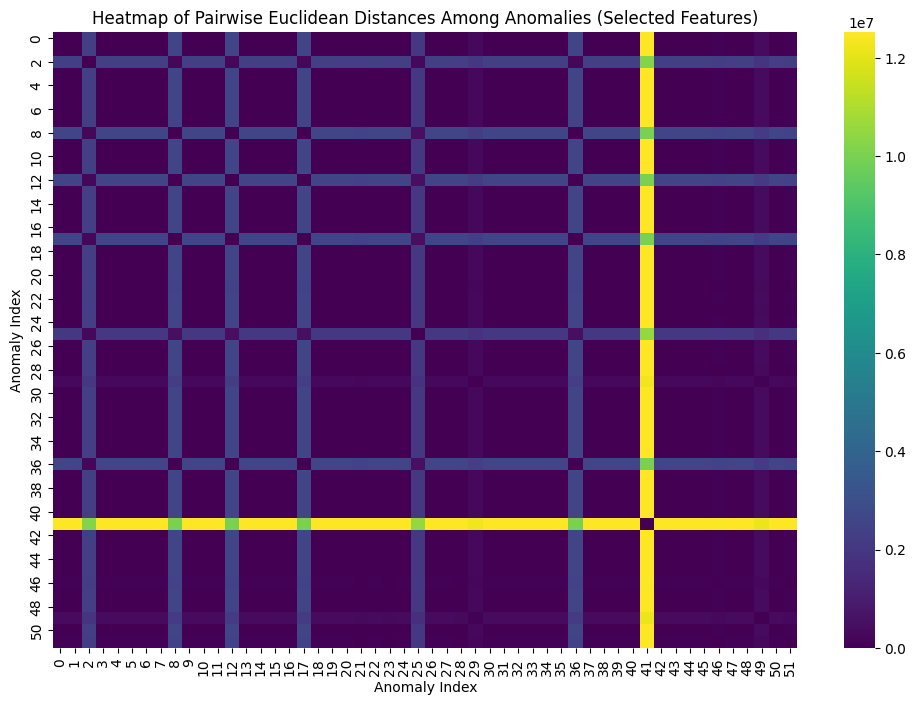

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# 1. Compute pairwise Euclidean distances
distances = pdist(anomaly_values, metric='euclidean')

# 2. Calculate the mean pairwise distance
mean_distance = np.mean(distances)
print("Mean pairwise distance among anomalies in the selected features:", mean_distance)

# 3. Convert distances into a square matrix
distance_matrix = squareform(distances)

# 4. Plot the heatmap of pairwise distances
plt.figure(figsize=(12, 8))
sns.heatmap(distance_matrix, cmap="viridis")
plt.title("Heatmap of Pairwise Euclidean Distances Among Anomalies (Selected Features)")
plt.xlabel("Anomaly Index")
plt.ylabel("Anomaly Index")
plt.show()


Top 5 features for clustering anomalies: ['weighted_utilization', 'utilization_rate', 'utilization_stability', 'cash_buffer_ratio', 'months_since_active']
Number of anomaly records: 52


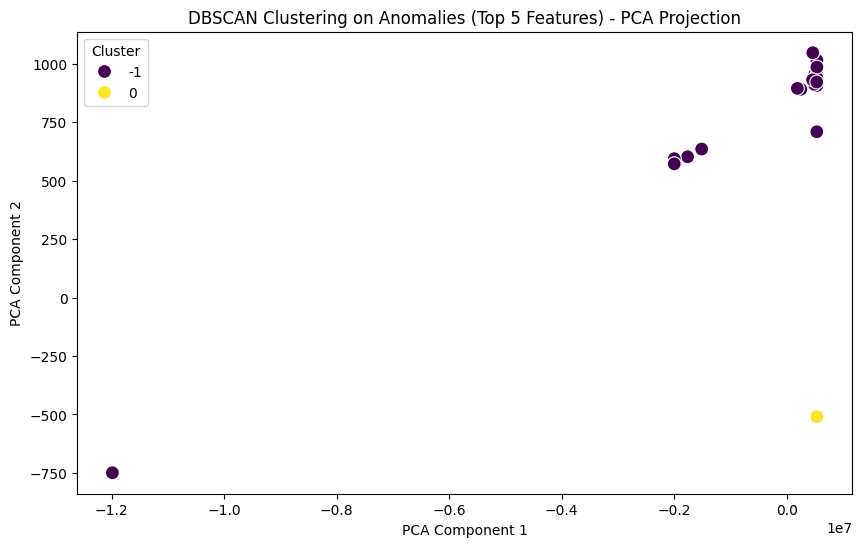

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# For this example, we assume that:
# - 'test_df' is your test set DataFrame with an 'anomaly_flag' column (1 for anomaly, 0 for normal)
# - 'top5_features' is a list containing the names of the top 5 features (e.g., derived from correlation analysis)
# - 'anomalies_only' is a DataFrame containing only the anomaly records from the test set

# Example: use top 5 features (you might have computed these earlier)
if 'top_features' in globals():
    top5_features = top_features[:5]
else:
    top5_features = risk_features[:5]

print("Top 5 features for clustering anomalies:", top5_features)

# Filter the test set to get only anomalies
anomalies_only = test_df[test_df['anomaly_flag'] == 1].copy()
print("Number of anomaly records:", anomalies_only.shape[0])

# Extract the values for the top 5 features
X_anomalies = anomalies_only[top5_features].values

# Apply DBSCAN clustering
# You might need to adjust eps and min_samples based on your data's scale
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_anomalies)

# Add cluster labels to the anomalies DataFrame
anomalies_only['cluster'] = dbscan_labels

# Use PCA to project the top 5 features into 2 dimensions for visualization
pca = PCA(n_components=2)
anomalies_pca = pca.fit_transform(X_anomalies)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=anomalies_pca[:, 0], y=anomalies_pca[:, 1], hue=anomalies_only['cluster'],
                palette='viridis', legend='full', s=100)
plt.title("DBSCAN Clustering on Anomalies (Top 5 Features) - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc='best')
plt.show()


Features used for pairwise scatter plots: ['weighted_utilization', 'utilization_rate', 'utilization_stability', 'cash_buffer_ratio', 'months_since_active', 'spending_to_balance_ratio', 'high_delinquency_flag']


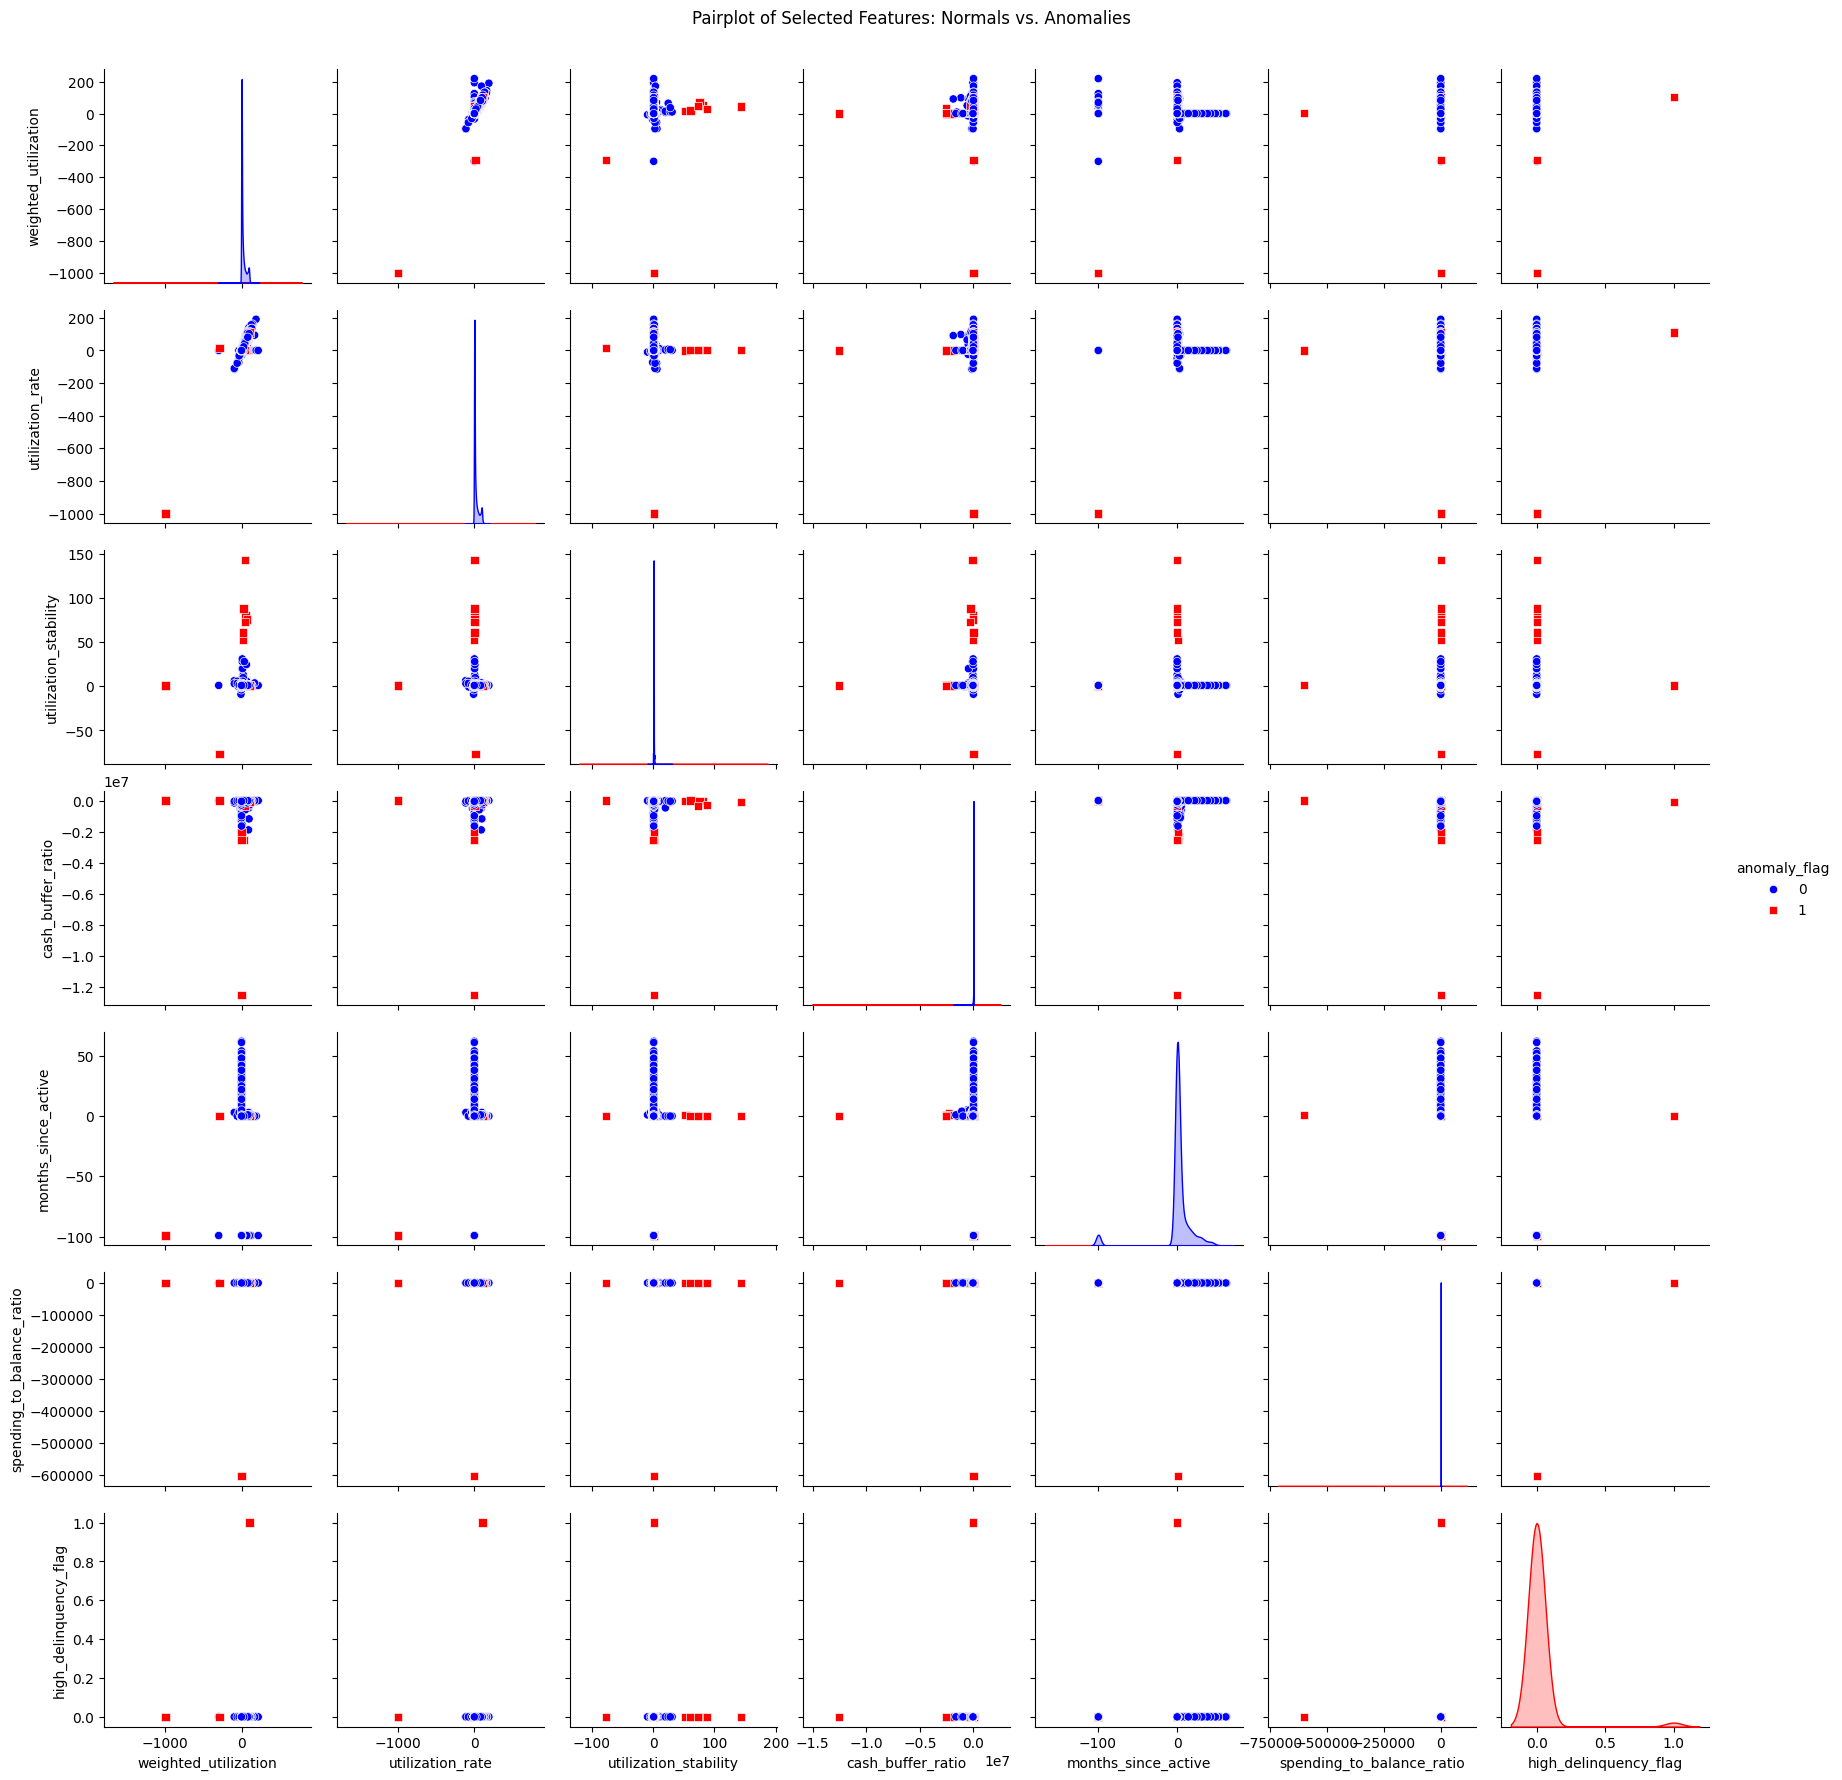

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the top 5 to 10 features you want to visualize.
# Here, we use 7 features as an example.
if 'top_features' in globals():
    features_for_scatter = top_features[:7]
else:
    # If you haven't defined top_features, use the first 7 of risk_features.
    features_for_scatter = risk_features[:7]

print("Features used for pairwise scatter plots:", features_for_scatter)

# Create a subset of the test set with the selected features and the anomaly flag.
pairplot_data = test_df[features_for_scatter + ['anomaly_flag']]

# Use Seaborn's pairplot to plot scatter plots between each pair of features.
# The 'hue' parameter colors the points based on the anomaly flag.
sns.pairplot(pairplot_data, hue='anomaly_flag', palette={0: 'blue', 1: 'red'}, markers=["o", "s"])
plt.suptitle("Pairplot of Selected Features: Normals vs. Anomalies", y=1.02)
plt.show()
